In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
workers = 2

# Batch size during training
batch_size_train = 128
batch_size_test = 8

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data/', train=True, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size_train, shuffle=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data/', train=False, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size_test, shuffle=False, pin_memory=True)


In [4]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
      super(Generator, self).__init__()
      self.network = nn.Sequential(
          nn.ConvTranspose2d(nz, ngf*4, 4, 1, 0, bias=False),
          nn.BatchNorm2d(ngf*4),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(ngf*4, ngf*2, 3, 2, 1, bias=False),
          nn.BatchNorm2d(ngf*2),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf),
          nn.ReLU(True),
  
          nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
          nn.Tanh()
      )
  
    def forward(self, input):
      output = self.network(input)
      return output

In [7]:
netG = Generator(nc, nz, ngf).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (network): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [8]:
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
                
                nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                
                nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                
                nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                
                nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
                nn.Sigmoid()
            )
    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(1)

In [9]:
netD = Discriminator(nc, ndf).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [10]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [11]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the train_loader
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/100][0/469]	Loss_D: 1.5788	Loss_G: 1.1167	D(x): 0.3786	D(G(z)): 0.4132 / 0.3449
[0/100][50/469]	Loss_D: 0.1706	Loss_G: 3.3380	D(x): 0.9136	D(G(z)): 0.0682 / 0.0447
[0/100][100/469]	Loss_D: 0.2416	Loss_G: 5.0907	D(x): 0.8158	D(G(z)): 0.0093 / 0.0114
[0/100][150/469]	Loss_D: 0.2411	Loss_G: 3.7091	D(x): 0.9063	D(G(z)): 0.1221 / 0.0319
[0/100][200/469]	Loss_D: 0.1301	Loss_G: 3.3814	D(x): 0.9188	D(G(z)): 0.0381 / 0.0450
[0/100][250/469]	Loss_D: 0.1116	Loss_G: 3.6527	D(x): 0.9459	D(G(z)): 0.0520 / 0.0316
[0/100][300/469]	Loss_D: 0.1220	Loss_G: 2.9434	D(x): 0.9147	D(G(z)): 0.0294 / 0.0678
[0/100][350/469]	Loss_D: 0.1163	Loss_G: 3.4707	D(x): 0.9390	D(G(z)): 0.0490 / 0.0413
[0/100][400/469]	Loss_D: 0.1017	Loss_G: 3.4015	D(x): 0.9466	D(G(z)): 0.0436 / 0.0448
[0/100][450/469]	Loss_D: 0.1884	Loss_G: 2.8237	D(x): 0.9324	D(G(z)): 0.1041 / 0.0790
[1/100][0/469]	Loss_D: 0.1135	Loss_G: 3.3586	D(x): 0.9319	D(G(z)): 0.0397 / 0.0449
[1/100][50/469]	Loss_D: 0.0980	Loss_G: 3.382

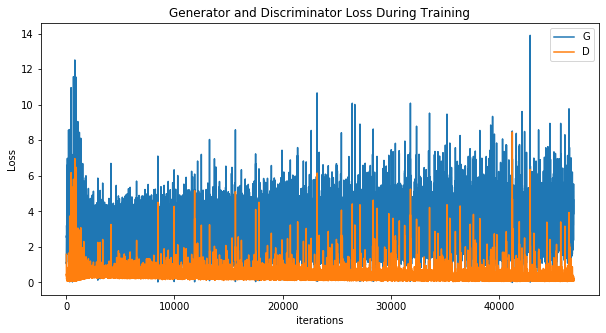

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

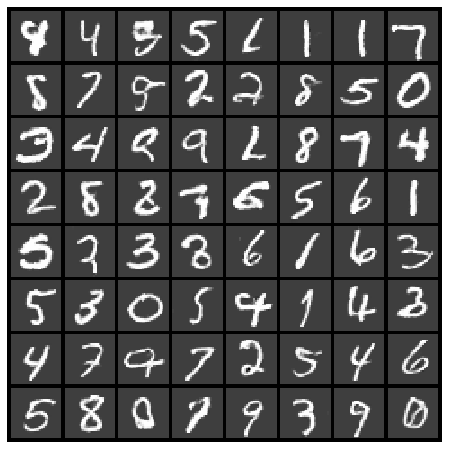

In [13]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())